## Source code

### Užklausos, su kuriomis galima peržiūrinėti uždavinius, jų komplektus ir sprendimus

In [1]:
import json
from IPython.display import display, Markdown
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mlc
import numpy as np
from itertools import chain, compress
from io import StringIO
import pandas as pd


def read_json(file):
    with open(file, encoding='utf-8') as fh:
        data = json.loads(fh.read())
    return data

def document_it(clusters, branches):
    clusters = read_json(clusters)
    branches = read_json(branches)
    headings = dict(zip([clusters[n][0] for n in clusters], clusters))
    docstring = ''
    for branch in branches:
        if branch in headings:
            docstring += f'\n### {headings[branch]}\n\n'
        docstring += f'* **{branch}.** {branches[branch]}\n'
    return docstring

def make_some_bank(*files, extention='.txt'):
    docstring = ''
    for file in files:
        heading = os.path.splitext(file)[0]
        docstring += f'\n### {heading}\n'
        bank = read_json(file + extention)
        for užduotis in bank:
            docstring += f"{užduotis}\\. {bank[užduotis]['Sąlyga']}"+'\n\n'
    return docstring

def show_problem(complect, id, show_solution=True):
    problem = read_json(f'{complect}.txt')[id]
    step = '**Užduotis.**\n\n' + problem["Sąlyga"]
    if show_solution: step += ('\n\n**Sprendimas.**\n' + '\n'.join([f'* {n}' for n in problem["Sprendimas"]]))
    return step

def show_case(complect, id, which=1, show_solution=True):
    skills = read_json(f'{complect}.txt')[id]["Gebėjimai"][which-1]
    step = '**Uždavinio dalis ' + f"{which}, kurioje yra {skills['Gebėjimas']}" + '.**\n\n' + skills['Atitikmuo']
    if show_solution: step += ('\n\n**Sprendimas.**\n\n' + skills['Sprendimas'])
    return step
    
def show_skill(skill, *files, extention='.txt'):
    counter = 0
    docstring = f'### Uždaviniai[@], kuriuose yra {skill}: \n\n'
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extention)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if gebėjimas['Gebėjimas'] == skill:
                    counter +=1 
                    docstring += f"**{heading}.{užduotis}->{idx+1}** {gebėjimas['Atitikmuo']}\n\n"
                else: #expects to have just a list of skills without dict of descriptions
                    if gebėjimas == skill:
                        counter +=1
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {bank[užduotis]['Sąlyga']}\n\n"
    return docstring.replace('@', str(counter))

def get_analysis(*files, extension='.txt'):
    skills = defaultdict(list)
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extension)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if type(gebėjimas) is dict:
                    skills[gebėjimas['Gebėjimas']].append(f"{heading}.{užduotis}->{idx+1}")
                else:
                    skills[gebėjimas].append(f"{heading}.{užduotis}->{idx+1}")
    return skills

def check(name, problem_id, extension='.txt'):
    display(Markdown(show_problem(name, problem_id, show_solution=True)))
    problem = read_json(name + extension)
    for i in range(len(problem[problem_id]['Gebėjimai'])): 
        display(Markdown('-'*100))
        display(Markdown(show_case(name, problem_id, which=i+1, show_solution=True)))

def check_skills(name, problem_id, extension='.txt'):
    problem = read_json(name + extension)
    return [n['Gebėjimas'] for n in problem[problem_id]['Gebėjimai']]

def get_distribution(cluster_file, *files):
    analysis = get_analysis(*files)
    print(analysis)
    branch_counts = defaultdict(int)
    for branch in analysis:
        branch_counts[branch] += len(analysis[branch])
    clusters = read_json(cluster_file)
    d = dict()
    for cluster in clusters:
        bc = dict()
        for branch in clusters[cluster]:
            bc[branch] = branch_counts[branch]
            branch_counts.pop(branch)
        d[cluster] = bc
    if len(branch_counts):
        print('WARNING! Some problems contain skills that are not in clusters:\n', branch_counts)
    return d

class Skills:
    kw = dict(bbox=dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.72),
          arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    cmap = plt.get_cmap("jet")
    
    def __init__(self, clusters_file, *files):
        self.distribution = get_distribution(clusters_file, *files)
        
    def set_diagram(self):
        self.inner_names = list(self.distribution.keys()) #clusters
        self.outer_names = list(chain(*[list(n.keys()) for n in self.distribution.values()])) #branches of clusters
        
        self.outer_values = np.array(list(chain(*[list(n.values()) for n in self.distribution.values()]))) #sizes of branches in each cluster
        self.inner_values = np.array([sum(n.values()) for n in self.distribution.values()]) #sizes of clusters
        
        self.inner_idx = np.flatnonzero(self.inner_values) #idx of nonzero inner values
        self.outer_idx = np.flatnonzero(self.outer_values) #idx of nonzero outer values

    def set_colors(self):
        self.set_diagram()
        marker_idx = np.cumsum([len(n) for n in self.distribution.values()])[:-1] #idx where to split flat data
        outer_spectrum = np.linspace(0, 1, len(self.outer_values))
        inner_spectrum = np.array([np.mean(n) for n in np.split(outer_spectrum, marker_idx)])        
        self.inner_colors = self.cmap(inner_spectrum)
        self.outer_colors = self.cmap(outer_spectrum)

    def flatnonzero(self):
        #remove zero pieces which is illegal
        self.inner_names = np.array(self.inner_names)[self.inner_idx]
        self.outer_names = np.array(self.outer_names)[self.outer_idx]
        self.inner_values = self.inner_values[self.inner_idx]
        self.outer_values = self.outer_values[self.outer_idx]
        self.inner_colors = self.inner_colors[self.inner_idx]
        self.outer_colors = self.outer_colors[self.outer_idx]
                                  
    def get_inner_pie(self):
        wedges, text = plt.gca().pie(self.inner_values, labels = self.inner_names, labeldistance=0.5, radius=0.5, colors=self.inner_colors, 
                                wedgeprops=dict(width=0.2, edgecolor='w'), textprops=dict(fontsize=15, fontweight='bold'))
        return wedges
    
    def get_outer_pie(self):
        wedges, text = plt.gca().pie(self.outer_values, radius=1, colors=self.outer_colors, 
                                wedgeprops=dict(width=0.5, edgecolor='w'))
        return wedges
                     
    def add_labels(self, wedges):
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle, angleA=0, angleB={ang}"
            self.kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.gca().annotate(self.outer_names[i], xy=(x, y), xytext=(1.35*np.sin(x), 1.4*y),
                        horizontalalignment=horizontalalignment, fontsize=11, fontweight='bold', **self.kw)
                                  
    def plot(self):
        fig = plt.figure(figsize=(6, 6))
        plt.gca().set(aspect="equal")
        self.set_diagram()
        self.set_colors()
        self.flatnonzero()
        wedges = self.get_outer_pie()
        self.get_inner_pie()
        self.add_labels(wedges)
        plt.show()
    
def get_data(text):
    df = pd.read_csv(StringIO(text), sep=" ")
    df.set_index(['author', 'topic','problem_id'], inplace=True)
    df1 = df[df['part']==0]
    df2 = df[df['part']!=0]
    df3 = pd.concat([df1, df2]).sort_values(by=['part'])
    df3 = df3[~df3.index.duplicated(keep='first')]
    df3['solved'][df3['part']!=0] = None
    df3 = df3.drop('part', 1)
    df3['skills'] = [tuple([n['Gebėjimas'] for n in read_json(f'{x}/{y}.txt')[str(z)]['Gebėjimai']]) for x,y,z in df3.index]
    df3['pts'] = [len(n) for n in df3['skills']]
    df4 = df3.copy()
    part = df3.loc[df3.index.repeat(df3['pts'])].groupby(['author', 'topic', 'problem_id']).cumcount() + 1
    df4 = pd.DataFrame(part, columns=['part'])
    df4['skill'] = list(chain(*df3['skills']))
    df5 = df4.merge(df2, on=['author', 'topic', 'problem_id', 'part'], how='outer')
    for n in df3[df3['solved']==True].index: 
        df5.loc[n, 'solved'] = True
    return df3, df5

def achievements(df5, df3, colors):
    vals_big = np.array([n if n == n else -1 for n in df5['solved'].values.tolist()]).astype(int)
    vals_small = np.array([n if n == n else -1 for n in df3['solved'].values.tolist()]).astype(int)
    img = vals_big[:, None]
    completed = df3['pts'].values
    shape = img.shape

    figure, ax = plt.subplots(figsize=(6,8))

    #x.set_xlabel('Activity', fontsize=13)
    #ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold', minor=False)
    ax.set_yticks(np.arange(-0.5+0.5, img.shape[0]+0.5, 1)) #borders between edges
    ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold')
    ax.set_ylim(-0.5, img.shape[0]-0.5)
    #ax.set_xticklabels(np.arange(1, img.shape[1] + 1, 1))

    #ax.set_ylabel('States', fontsize=13)
    ax.set_xticks(np.arange(0, 1, 1))
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    #ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    #ax.set_yticklabels(states)

    a=0.05
    pal = {1: 'none', 0: 'red', -1: 'grey'}
    for idx, clr in enumerate(colors):
        if vals_big[idx]!=-1:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor=clr, edgecolor = pal[vals_big[idx]], hatch=r'xxx', zorder=0))
        else:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor='none', edgecolor = pal[vals_big[idx]], hatch=r'xxx'))
        
    pallete = {1: 'limegreen', 0: 'crimson', -1: 'none'}
    starts, sizes = np.cumsum(np.r_[0, df3['pts'].values[:-1]]), np.r_[df3['pts'].values]
    for start, size, solved in zip(starts, sizes, vals_small):
        ax.add_patch(plt.Rectangle((-0.5+a, start-0.5+a), 1-2*a, size-2*a, 
                                   facecolor='none', edgecolor = pallete[solved], zorder=1, lw=4, linestyle='--'))
    
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()

    
    ax.grid(which='minor', color='k')
    ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
    plt.gca().invert_yaxis()
    #plt.gca().majorticks_off()
    plt.show()

### Klasė, su kuria galima pasivaizduoti, ką sprendėme

In [2]:
import math
import matplotlib.patches as patches 
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm 
import textwrap

class Summary:
    def __init__(self, lesson_df):
        self.lesson_df = lesson_df
        
    def get_colors(self, clusters):
        skills = []
        for n in read_json(clusters).values():
            skills.extend(n)

        idx = [skills.index(n) for n in self.lesson_df['skill']]
        palette = plt.get_cmap('jet')(np.linspace(0, 1, len(skills)))
        colors = palette[idx]
        return colors
        
    def add_summary(self, colors, mode = 'abstract', height=10, width=30, 
                    fixes={'\\boxed': '', '\\sin': '\\cos'}, figsize=(6,8), wrapping=50):
        groupby = self.lesson_df.groupby(['author', 'topic', 'problem_id'], sort=False)
        chunk_sizes = groupby.size().values
        chunk_values = groupby.nth(0)['solved_fully'].values
        figure, ax = plt.subplots(figsize = figsize, dpi=100)


        ax.set_xticks(np.arange(0, width, width))
        ax.get_xaxis().set_visible(False)
        ax.set_xlim(0, width)

        a=0.05
        
        # Full rectangles
        pallete = {1: 'green', 0: 'brown'}
        yticks = []
        for start, size, solved in zip(np.cumsum(np.r_[0, chunk_sizes[:-1]]), chunk_sizes, chunk_values):
            box_position = height * (start+size/2)
            yticks.append(box_position)
            if not math.isnan(solved):
                rect = patches.Rectangle((-0.5*width, start*height+ height/2), width, size*height, facecolor='none')
                offsetbox = AuxTransformBox(ax.transData)
                offsetbox.add_artist(rect)
                ab = AnnotationBbox(offsetbox, (width/2, box_position),
                                    boxcoords="data", pad=-0.62,fontsize=4,
                                    bboxprops=dict(facecolor = "none", edgecolor=pallete[solved], 
                                              lw = 4))
                ax.add_artist(ab)
                
                
            else:
                ax.add_patch(plt.Rectangle((0, (start-0.5)*height), width, size*height, 
                                           facecolor='none', edgecolor = 'none', zorder=1, lw=4, linestyle='--'))
        
        # Partial rectangles
        for idx, clr in enumerate(colors):
            point = self.lesson_df['solved_partially'][idx]
            if math.isnan(point):
                ax.add_patch(plt.Rectangle((0, idx*height), width, height, facecolor='none', edgecolor = 'grey', hatch=r'xxx'))
            else:
                s = {True: 0.65, False: 0}[point]
                rectangle = patches.Rectangle((0, idx*height), width, height, facecolor=clr, 
                                           edgecolor = 'k', hatch=r'xxx', zorder=0)
                ax.add_patch(rectangle)
                
                #clip your colors here
                cell = (np.sin(np.linspace(0, np.pi, height)[:, np.newaxis]) * np.cos(np.linspace(-np.pi/2, np.pi/2, width))**0.5)
                col = np.c_[np.linspace(clr[0], clr[0]*s, 20),
                          np.linspace(clr[1], clr[1]*s, 20), 
                          np.linspace(clr[2], clr[2]*s, 20),
                          np.ones(20)]
                im = ax.imshow(cell, interpolation ='bicubic', cmap = ListedColormap(col), extent = (0, width, idx*height, (idx+1)*height))
                im.set_clip_path(rectangle)
              
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        
        if mode == 'abstract':
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(self.lesson_df['skill'].values, rotation='horizontal', fontsize=12, fontweight='bold')

        elif mode == 'real':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]['Sąlyga']
                problems.append(self.entering(self.parse_exception(u, fixes), wrapping=wrapping))

            ax.set_yticks(yticks)
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')
        
        elif mode == 'full':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]
                point_names = [self.entering(self.parse_exception(p['Atitikmuo'], fixes), wrapping=wrapping) for p in u['Gebėjimai']]
                if len(point_names) == 1:
                    problems.append(self.entering(self.parse_exception(u['Sąlyga'], fixes), wrapping=wrapping))
                else:
                    problems.extend(point_names)
                    
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')

        ax.set_ylim(0, len(self.lesson_df) * height)
        
        ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
        #ax.tick_params(axis='y', which='major', right=False) #might this help to extend plot
        plt.gca().invert_yaxis()
        plt.show()
    
    @staticmethod
    def parse_exception(text, fixes={}):
        for n in fixes:
            text = text.replace(n, fixes[n])
        return text
    
    @staticmethod
    def entering(text, wrapping=100):
        se = np.array([m.start() for m in re.finditer(r"(?=\$)", text)])
        if len(se):
            se = se.reshape(-1, 2) + (0, 1)
            forward = dict((text[s[0]:s[1]], str(np.random.randint(1000000000))) for s in se)
            backward = dict((forward[n], n) for n in forward)

            for n in forward:
                text = text.replace(n, forward[n])
            out_text = '\n'.join(textwrap.wrap(text, width=wrapping))
            
            for n in backward:
                out_text = out_text.replace(n, backward[n])
            return out_text
        else:
            return '\n'.join(textwrap.wrap(text, width=wrapping))
    
    
        
#Jei prireiks - uždavinių rūšiavimas pagal numerius
import re
def argsort_problems(problem_ids):
    keys = [re.match(r'(\d*)(.*)', s).groups() for s in problem_ids]
    keys = [(int(num), ord(letters)) if letters else (int(num), 0) for num, letters in keys]
    sorter = np.ravel_multi_index(np.array(keys).T, (256, 256))
    return np.argsort(sorter)

### Klasė, kuri nuskaito pamokos duomenis

In [3]:
class Lesson:
    def __init__(self, text):
        self.df = pd.read_csv(StringIO(text), sep=" ")
        self.df.set_index(['author', 'topic','problem_id'], inplace=True)

    def analyse_problems(self):
        # analysis on every problem_id or its part attempted based on metadata; no scoring
        skills, pts = [], []
        for problem in self.df.index.unique():
            author, topic, problem_id = problem
            metadata = read_json(f'{author}/{topic}.txt')
            problem_data = metadata[str(problem_id)]['Gebėjimai']
            problem_skills = [n['Gebėjimas'] for n in problem_data]
            skills.append(problem_skills)
            pts.append(len(problem_skills))
        self.problems_df = pd.DataFrame({'skills': skills, 'pts': pts}, index = self.df.index.unique())

    def analyse_points(self):
        # creates a span of point_ids for every problem_id and extracts skills from self.problems_df; no scoring
        self.analyse_problems()
        multi_idx = self.problems_df.index
        point_series = self.problems_df.loc[multi_idx.repeat(self.problems_df['pts'])].groupby(multi_idx.names).cumcount() + 1
        skill = list(chain(*self.problems_df['skills']))
        self.points_df = pd.DataFrame({'point_id': point_series.values, 'skill': skill}, index = point_series.index)

    def check_solutions(self):
        # scoring of full solutions + partial solutions; combines solution with metadata of problems & points
        self.analyse_points()
        df1 = self.df[self.df['point_id']==0]
        df2 = self.df[self.df['point_id']!=0]
        df2 = df2.reset_index().set_index(['author', 'topic', 'problem_id', 'point_id'])
        self.points_df.loc[df1.index, 'solved_fully'] = df1['solved']
        self.points_df = self.points_df.reset_index().set_index(['author', 'topic', 'problem_id','point_id'])
        self.points_df.loc[df2.index, 'solved_partially'] = df2['solved']

    def fix_typos(self):
        # typos of any of these kinds:
        # * if solved fully, all the partial solutions becomes right
        # * if any partial solution not right, it's not solved fully
        # * except the case there are not attempted partial solutions; it makes a full solution not attempted as well
        self.check_solutions()
        df = self.points_df
        df.loc[df['solved_fully'] == True, 'solved_partially'] = True
        df = df.reset_index().set_index(['author', 'topic', 'problem_id'])
        df.loc[(df['solved_partially'] == False).index, 'solved_fully'] = False
        df.loc[df['solved_partially'].isnull().index, 'solved_fully'] = np.nan
    
    def get_lesson(self):
        self.fix_typos()
        return self.points_df

## Usage

### Parodyk reikalavimų sąrašą

In [30]:
display(Markdown(document_it(r'vbe\clusters.txt', r'vbe\branches.txt')))


### Algebra

* **Elementariosios matematikos gebėjimai.** Tiesinės ir kvadratinės lygtys, nelygybės ir jų sistemos, daugianarių sudėtis ir daugyba, reiškinių prastinimai, elementarūs aritmetiniai veiksmai.
* **Reiškinių sudarymas.** Gebėjimas pagal uždavinio sąlygą sudaryti nesudėtingus raidinius arba skaitinius reiškinius, lygtis, nelygybes arba jų sistemas, reikšmių kontroliavimas (stebėjimas, kaip pakinta vienas dydis kintant kitam). Sudarytų reiškinių interpretavimas. Greičio, kelio ir laiko sąryšiai.
* **Progresijos.** Aritmetinės ir geometrinės progresijos savybių taikymas.
* **Palūkanos ir procentai.** Raidinių arba skaitinių reiškinių sudarymas panaudojant procentus, sudėtinės palūkanos.
* **Logaritmai.** Logaritmų tapatybių taikymas, logaritminės lygtys ir nelygybės.
* **Laipsniai ir šaknys.** Laipsnių ir šaknų savybių taikymas.

### Funkcijos

* **Funkcijos.** Reikšmės radimas žinant argumentą ir argumento radimas žinant reikšmę, skaičiaus, kintamojo, reiškinio ar funkcijos įstatymas į įvairias išraiškas, funkcijų grafikų interpretavimas, apibrėžimo sritis, veiksmai su intervalais.
* **Išvestinės.** Išvestinių savybės, išvestinių skaičiavimas, funkcijų minimumai ir maksimumai, liestinių lygtys, geometrinė išvestinės interpretacija.
* **Integralai.** Integralo panaudojimas funkcijų ribojamam plotui skaičiuoti, nesudėtingų reiškinių integravimas.

### Geometrija

* **Geometrija.** Plokštumos figūrų savybės.
* **Trigonometrija.** Kampų konvertavimas į radianus ir atvirkščiai. Trigometrinių funkcijų ir joms atvirkštinių reikšmių radimas, kai žinomas jų argumentas. Trigonometrinių tapatybių taikymas, kraštinių sąryšiai stačiajame trikampyje, Sinusų ir Kosinusų teoremos, atvirkštinės trigonometrinės funkcijos, trigonometrinės lygtys ir nelygybės.
* **Vektoriai.** Vektorių sudėtis ir atimtis, vektorinė ir skaliarinė sandaugos, kolinearumas, statmenumas, vieno vektoriaus išreiškimas per kitus, vektoriaus modulis.
* **Erdvės geometrija.** Erdvinių kūnų tūriai ir paviršiaus plotai, uždaviniai su keliomis plokštumomis.

### Kombinatorika

* **Tikimybių teorija.** Tiesiog tikimybės
* **Statistika.** Imtis, moda, mediana, vidurkis, dispersija, dažnių lentelės.
* **Kombinatorika.** Deriniai, kėliniai, gretiniai.


### Parodyk uždavinių komplektą

In [4]:
display(Markdown(make_some_bank('vbe/2015')))


### vbe/2015
1\. Kuris iš pateiktų eskizų yra funkcijos grafiko $y=2^x$ eskizas? ![](vbe\VBE2015_1.PNG)

2\. Sekos bendrasis narys užrašomas formule $a_n=3n-1$ $(n=1,2,3,\dots)$. Kam lygus jos penktasis narys $a_5$?

3\.  Diagramoje pavaizduotas šeimos vieno mėnesio visų išlaidų paskirstymas procentais. Tą mėnesį **maistui** šeima išleido 420 eurų. Kiek eurų šeima išleido rūbams? ![](vbe\VBE2015_3.PNG)

4\. Kam lygi imties 5;14;11;6;5;10;12 mediana?

5\. Vandens čiaupo pajėgumas yra toks, kad stačiakampio gretasienio formos baseinas, kurio matmenys yra $a$, $b$ ir $c$, pripildomas per 1 valandą. Per kiek laiko iš to paties vandens čiaupo, veikiančio tokiu pačiu pajėgumu, galima būtų pripildyti stačiakampio gretasienio formos $2a$, $2b$ ir $2c$ matmenų baseiną?

6\. Išspręskite lygtį $(x+2011)(x+2013)(x+2014)=(x+2013)(x+2014)(x+2015)$

7\. Su kuria $x$ reikšme vektoriai $\overrightarrow{a}=(x; 3)$ ir $\overrightarrow{b}=(-2; 6)$ yra kolinearūs?

8\. Paveiksle pavaizduotas kubas $ABCDA_1B_1C_1D_1$ Raskite kampo tarp tiesių, kuriose yra kubo sienų įstrižainės $A_1B$ ir $B_1C$ didumą. ![](vbe\VBE2015_8.png)

9\. Seifo kodą turi sudaryti trys skirtingi skaitmenys, užrašyti didėjimo tvarka. Kiek tokių skirtingų kodų galima sudaryti?

10\. Žinoma, kad funkcija $f(x)$ yra lyginė, o $g(x)$ - nelyginė. Apskaičiuokite $g(f(-a))+f(g(b))$, jei $f(a)=-b$, $g(-b)=a$, kur $a\neq 0$, $b\neq 0$

11\. $A=[-2; 4)$ ir $B=(-6;3)$ sankirtą $A\bigcap B$

12a\. Išspręskite lygtį $5^{2x}=125$

12b\. Išspręskite lygtį $|x-2|=5$

13a\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle ACB$ didumą ![](vbe\VBE2015_13.PNG)

13b\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle AMB$ didumą ![](vbe\VBE2015_13.PNG)

14\. Ritinio pagrindo apskritimo ilgis lygus 30, o ritinio aukštinės ilgis lygus 6. Apskaičiuokite šio ritinio šoninio paviršiaus plotą. ![](vbe\VBE2015_14.PNG)

15a\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos reikšmių didėjimo intervalą (-us)

15b\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos minimumo tašką.

16\. Keturkampis $ABCD$ yra rombas. Raskite vektorių, lygų vektorių sumai $\overrightarrow{AB}+\overrightarrow{AD}$ ![](vbe\VBE2015_16.PNG)

16a\. Keturkampis $ABCD$ yra rombas. Raskite vektorių, lygų vektorių sumai $\overrightarrow{AB}+\overrightarrow{AD}$ ![](vbe\VBE2015_16.PNG)

16b\. Keturkampis $ABCD$ yra rombas. Raskite vektorių skaliarinę sandaugą $\overrightarrow{BD}\cdot \overrightarrow{AC}$ ![](vbe\VBE2015_16.PNG)

17\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Nustatykite vandens lygį uoste 9 valandą ryto

17a\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Nustatykite vandens lygį uoste 9 valandą ryto

17b\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Didžiausią galimą $d$ reikšmę



### Parodyk tam tikrą uždavinį, jei reikia, su sprendimu

In [5]:
display(Markdown(show_problem('vbe/2015', '10', show_solution=True)))

**Užduotis.**

Žinoma, kad funkcija $f(x)$ yra lyginė, o $g(x)$ - nelyginė. Apskaičiuokite $g(f(-a))+f(g(b))$, jei $f(a)=-b$, $g(-b)=a$, kur $a\neq 0$, $b\neq 0$

**Sprendimas.**
* $f(-a)=f(a)=-b$ pagal lyginės funkcijos apibrėžimą
* $g(b)=g(-b)=a$ pagal nelyginės funkcijos apibrėžimą
* $g(f(-a))+f(g(b))=g(-b)+f(a)$ pagal gautus teiginius
* $g(-b)+f(a) = a-b$ pagal sąlygą

### Parodyk tam tikrą uždavinio dalį, jei reikia, su sprendimu

In [7]:
display(Markdown(show_case('licejus/2017', '2', which=1, show_solution=True)))

**Uždavinio dalis 1, kurioje yra $\mathbb{Z}$ ir $\mathbb{Q}$ operacijos.**

Jonas išlanksto lėktuvėlį per 3 minutes, o Zigmas tokį pat lėktuvėlį išlanksto per 4 minutes. Kurią dalį lėktuvėlio išlankstys per minutę kiekvienas atskirai ir kurią dirbdami kartu?

**Sprendimas.**

Jonas - $\displaystyle\frac{1}{3}$ lėktuvėlio, Zigmas - $\displaystyle\frac{1}{4}$, abu - $\displaystyle\frac{1}{3}+\frac{1}{4}=\frac{7}{12}$

### Išmesk kopijuojamą tekstą, kuris parodo rinkinį [gebėjimas -> uždavinių sąrašas]

In [11]:
get_analysis('vbe/2015')

defaultdict(list,
            {'Funkcijos': ['vbe/2015.1->1', 'vbe/2015.2->1', 'vbe/2015.11->1'],
             'Palūkanos ir procentai': ['vbe/2015.3->1'],
             'Statistika': ['vbe/2015.4->1'],
             'Reiškinių sudarymas': ['vbe/2015.5->1'],
             'Elementariosios matematikos gebėjimai': ['vbe/2015.6->1',
              'vbe/2015.12b->1'],
             'Vektoriai': ['vbe/2015.7->1',
              'vbe/2015.16a->1',
              'vbe/2015.16b->1'],
             'Erdvės geometrija': ['vbe/2015.8->1', 'vbe/2015.14->1'],
             'Kombinatorika': ['vbe/2015.9->1', 'vbe/2015.10->1'],
             'Laipsniai ir šaknys': ['vbe/2015.12a->1'],
             'Geometrija': ['vbe/2015.13a->1', 'vbe/2015.13b->1'],
             'Išvestinės': ['vbe/2015.15a->1', 'vbe/2015.15b->1'],
             'Trigonometrija': ['vbe/2015.17a->1', 'vbe/2015.17b->1']})

### Parodyk visus uždavinius, kuriems reikia tam tikro gebėjimo [veikia su klaidomis, nerodo variantų]

In [13]:
display(Markdown(show_skill('Kombinatorika', 'vbe/2015'))) #additional files allowed

### Uždaviniai[2], kuriuose yra Kombinatorika: 

**vbe/2015.9->1** 

**vbe/2015.10->1** 



### Pavaizduok duoto uždavinių komplekto gebėjimų pasiskirstymą

defaultdict(<class 'list'>, {'Funkcijos': ['vbe/2015.1->1', 'vbe/2015.2->1', 'vbe/2015.11->1'], 'Palūkanos ir procentai': ['vbe/2015.3->1'], 'Statistika': ['vbe/2015.4->1'], 'Reiškinių sudarymas': ['vbe/2015.5->1'], 'Elementariosios matematikos gebėjimai': ['vbe/2015.6->1', 'vbe/2015.12b->1'], 'Vektoriai': ['vbe/2015.7->1', 'vbe/2015.16->1', 'vbe/2015.16a->1', 'vbe/2015.16b->1'], 'Erdvės geometrija': ['vbe/2015.8->1', 'vbe/2015.14->1'], 'Kombinatorika': ['vbe/2015.9->1', 'vbe/2015.10->1'], 'Laipsniai ir šaknys': ['vbe/2015.12a->1'], 'Geometrija': ['vbe/2015.13a->1', 'vbe/2015.13b->1'], 'Išvestinės': ['vbe/2015.15a->1', 'vbe/2015.15b->1'], 'Trigonometrija': ['vbe/2015.17->1', 'vbe/2015.17a->1', 'vbe/2015.17b->1']})


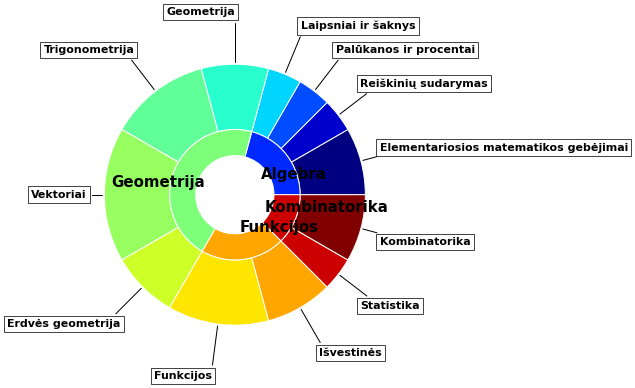

In [6]:
Skills('vbe/clusters.txt', 'vbe/2015').plot()

### Pavaizduok per pamoką spręstus uždavinius

In [15]:
display(Markdown(make_some_bank('vbe/2015')))


### vbe/2015
1\. Kuris iš pateiktų eskizų yra funkcijos grafiko $y=2^x$ eskizas? ![](vbe\VBE2015_1.PNG)

2\. Sekos bendrasis narys užrašomas formule $a_n=3n-1$ $(n=1,2,3,\dots)$. Kam lygus jos penktasis narys $a_5$?

3\.  Diagramoje pavaizduotas šeimos vieno mėnesio visų išlaidų paskirstymas procentais. Tą mėnesį **maistui** šeima išleido 420 eurų. Kiek eurų šeima išleido rūbams? ![](vbe\VBE2015_3.PNG)

4\. Kam lygi imties 5;14;11;6;5;10;12 mediana?

5\. Vandens čiaupo pajėgumas yra toks, kad stačiakampio gretasienio formos baseinas, kurio matmenys yra $a$, $b$ ir $c$, pripildomas per 1 valandą. Per kiek laiko iš to paties vandens čiaupo, veikiančio tokiu pačiu pajėgumu, galima būtų pripildyti stačiakampio gretasienio formos $2a$, $2b$ ir $2c$ matmenų baseiną?

6\. Išspręskite lygtį $(x+2011)(x+2013)(x+2014)=(x+2013)(x+2014)(x+2015)$

7\. Su kuria $x$ reikšme vektoriai $\overrightarrow{a}=(x; 3)$ ir $\overrightarrow{b}=(-2; 6)$ yra kolinearūs?

8\. Paveiksle pavaizduotas kubas $ABCDA_1B_1C_1D_1$ Raskite kampo tarp tiesių, kuriose yra kubo sienų įstrižainės $A_1B$ ir $B_1C$ didumą. ![](vbe\VBE2015_8.png)

9\. Seifo kodą turi sudaryti trys skirtingi skaitmenys, užrašyti didėjimo tvarka. Kiek tokių skirtingų kodų galima sudaryti?

10\. Žinoma, kad funkcija $f(x)$ yra lyginė, o $g(x)$ - nelyginė. Apskaičiuokite $g(f(-a))+f(g(b))$, jei $f(a)=-b$, $g(-b)=a$, kur $a\neq 0$, $b\neq 0$

11\. $A=[-2; 4)$ ir $B=(-6;3)$ sankirtą $A\bigcap B$

12a\. Išspręskite lygtį $5^{2x}=125$

12b\. Išspręskite lygtį $|x-2|=5$

13a\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle ACB$ didumą ![](vbe\VBE2015_13.PNG)

13b\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle AMB$ didumą ![](vbe\VBE2015_13.PNG)

14\. Ritinio pagrindo apskritimo ilgis lygus 30, o ritinio aukštinės ilgis lygus 6. Apskaičiuokite šio ritinio šoninio paviršiaus plotą. ![](vbe\VBE2015_14.PNG)

15a\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos reikšmių didėjimo intervalą (-us)

15b\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos minimumo tašką.

16a\. Keturkampis $ABCD$ yra rombas. Raskite vektorių, lygų vektorių sumai $\overrightarrow{AB}+\overrightarrow{AD}$ ![](vbe\VBE2015_16.PNG)

16b\. Keturkampis $ABCD$ yra rombas. Raskite vektorių skaliarinę sandaugą $\overrightarrow{BD}\cdot \overrightarrow{AC}$ ![](vbe\VBE2015_16.PNG)

17a\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Nustatykite vandens lygį uoste 9 valandą ryto

17b\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Didžiausią galimą $d$ reikšmę



### Detaliausia įmanoma uždavinio analizė

In [333]:
check('licejus/2017', '3a') # detaliausia analizė
check_skills('licejus/2017', '3b') #tik reikiami gebėjimai

**Užduotis.**

Suprastinkite reiškinį $\displaystyle\frac{1}{2}xy^{2}\cdot (-2x^2y)^{8}$ (2tšk.)

**Sprendimas.**
* $\displaystyle\frac{1}{2}xy^2\cdot (-2x^2y)^8 = 2^{-1}xy^2 \cdot 2^8x^{16}y^8 = 2^7x^{17}y^{10}=128x^{17}y^{10}$

----------------------------------------------------------------------------------------------------

**Uždavinio dalis 1, kurioje yra Laipsnių taikymas reiškiniuose.**

$(-2x^2y)^8 = ?$

**Sprendimas.**

$(-2x^2y)^8 = 2^8x^{16}y^8=256x^{16}y^8$

----------------------------------------------------------------------------------------------------

**Uždavinio dalis 2, kurioje yra Laipsnių taikymas reiškiniuose.**

$2^{-1}xy^2 \cdot 2^8x^{16}y^8=?$

**Sprendimas.**

$2^{-1}xy^2 \cdot 2^8x^{16}y^8 = 2^7x^{17}y^{10}=128x^{17}y^{10}$

['Laipsnių taikymas reiškiniuose', 'Laipsnių taikymas reiškiniuose']

### Pamokoje spręstų uždavinių duomenų bazė

In [7]:
text = """
author topic problem_id point_id solved
vbe 2015 1 0 True
vbe 2015 1 1 True
vbe 2015 2 0 True
vbe 2015 2 1 True
vbe 2015 3 0 True
vbe 2015 3 1 True
vbe 2015 4 0 False
vbe 2015 4 1 False
vbe 2015 5 0 True
vbe 2015 5 1 True
vbe 2015 6 0 False
vbe 2015 6 1 False
vbe 2015 7 0 False
vbe 2015 7 1 False
vbe 2015 8 0 False
vbe 2015 8 1 False
vbe 2015 9 0 False
vbe 2015 9 1 False
vbe 2015 10 0 False
vbe 2015 10 1 False
vbe 2015 11 0 False
vbe 2015 11 1 False
vbe 2015 12a 0 True
vbe 2015 12a 1 True
vbe 2015 12b 0 True
vbe 2015 12b 1 True
vbe 2015 13a 0 False
vbe 2015 13a 1 False
vbe 2015 13b 0 True
vbe 2015 13b 1 True
vbe 2015 14 0 False
vbe 2015 14 1 False
vbe 2015 15a 0 True
vbe 2015 15a 1 True
vbe 2015 15b 0 True
vbe 2015 15b 1 True
vbe 2015 16a 0 False
vbe 2015 16a 1 False
vbe 2015 16b 0 False
vbe 2015 16b 1 False
vbe 2015 17a 0 True
vbe 2015 17a 1 True
vbe 2015 17b 0 False
vbe 2015 17b 1 False
""" 
Lesson(text).get_lesson()

skill  \
author topic problem_id point_id                                          
vbe    2015  1          1                                     Funkcijos   
             2          1                                     Funkcijos   
             3          1                        Palūkanos ir procentai   
             4          1                                    Statistika   
             5          1                           Reiškinių sudarymas   
             6          1         Elementariosios matematikos gebėjimai   
             7          1                                     Vektoriai   
             8          1                             Erdvės geometrija   
             9          1                                 Kombinatorika   
             10         1                                 Kombinatorika   
             11         1                                     Funkcijos   
             12a        1                           Laipsniai ir šaknys   
             12b        1         Elementariosios matematikos gebėjimai   
             13a        1                                    Geometrija   
             13b        1                                    Geometrija   
             14         1                             Erdvės geometrija   
             15a        1                                    Išvestinės   
             15b        1                                    Išvestinės   
             16a        1                                     Vektoriai   
             16b        1                                     Vektoriai   
             17a        1                                Trigonometrija   
             17b        1                                Trigonometrija   

                                  solved_fully  solved_partially  
author topic problem_id point_id                                  
vbe    2015  1          1                 True              True  
             2          1                 True              True  
             3          1                 True              True  
             4          1                False             False  
             5          1                 True              True  
             6          1                False             False  
             7          1                False             False  
             8          1                False             False  
             9          1                False             False  
             10         1                False             False  
             11         1                False             False  
             12a        1                 True              True  
             12b        1                 True              True  
             13a        1                False             False  
             13b        1                 True              True  
             14         1                False             False  
             15a        1                 True              True  
             15b        1                 True              True  
             16a        1                False             False  
             16b        1                False             False  
             17a        1                 True              True  
             17b        1                False             False

### Trys būdai pavaizduoti pamokos darbą

In [8]:
#nepamiršti iš pradžių įrašyti pamokos duomenų į text kintamąjį
lesson_df = Lesson(text).get_lesson()
summary = Summary(lesson_df)
colors = summary.get_colors('vbe/clusters.txt')

# Nepainioti šakos su šakelėm! Kombinatorika nėra tas pats, kas sudėties ir daugybos taisyklės

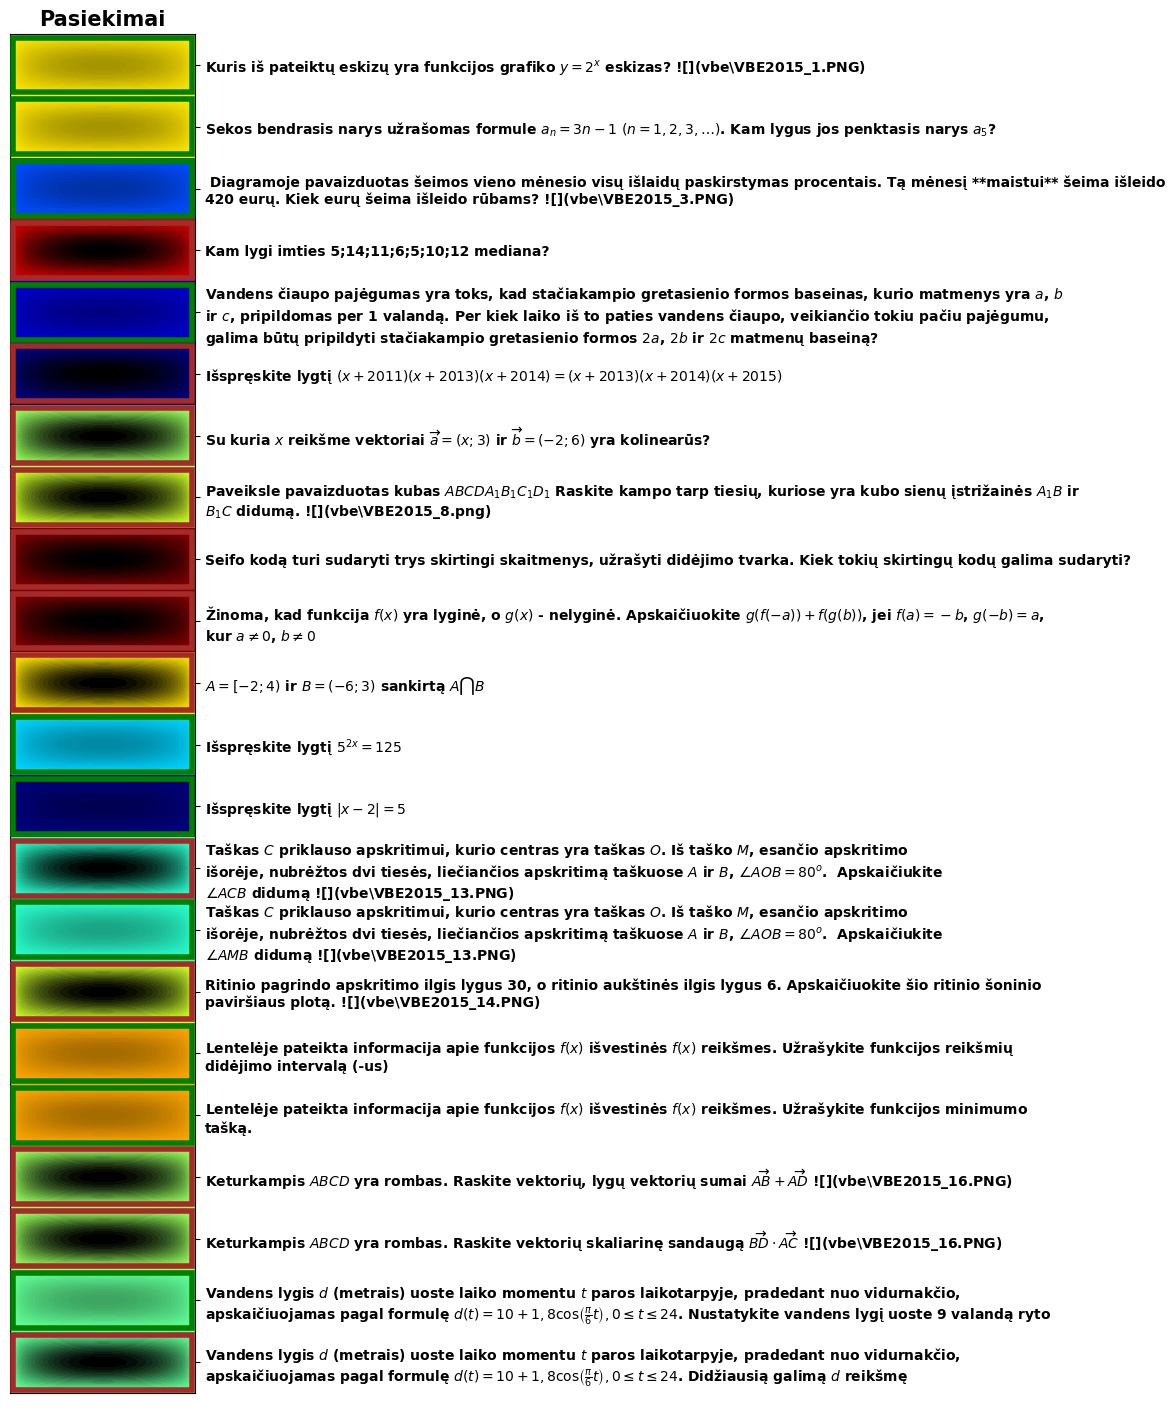

In [21]:
#summary.add_summary(colors, mode = 'abstract', figsize=(1.3,9))
summary.add_summary(colors, mode = 'real', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(8,18), wrapping=120)
#summary.add_summary(colors, mode = 'full', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(3,9), wrapping=100)

In [22]:
display(Markdown(make_some_bank('vbe/2015')))


### vbe/2015
1\. Kuris iš pateiktų eskizų yra funkcijos grafiko $y=2^x$ eskizas? ![](vbe\VBE2015_1.PNG)

2\. Sekos bendrasis narys užrašomas formule $a_n=3n-1$ $(n=1,2,3,\dots)$. Kam lygus jos penktasis narys $a_5$?

3\.  Diagramoje pavaizduotas šeimos vieno mėnesio visų išlaidų paskirstymas procentais. Tą mėnesį **maistui** šeima išleido 420 eurų. Kiek eurų šeima išleido rūbams? ![](vbe\VBE2015_3.PNG)

4\. Kam lygi imties 5;14;11;6;5;10;12 mediana?

5\. Vandens čiaupo pajėgumas yra toks, kad stačiakampio gretasienio formos baseinas, kurio matmenys yra $a$, $b$ ir $c$, pripildomas per 1 valandą. Per kiek laiko iš to paties vandens čiaupo, veikiančio tokiu pačiu pajėgumu, galima būtų pripildyti stačiakampio gretasienio formos $2a$, $2b$ ir $2c$ matmenų baseiną?

6\. Išspręskite lygtį $(x+2011)(x+2013)(x+2014)=(x+2013)(x+2014)(x+2015)$

7\. Su kuria $x$ reikšme vektoriai $\overrightarrow{a}=(x; 3)$ ir $\overrightarrow{b}=(-2; 6)$ yra kolinearūs?

8\. Paveiksle pavaizduotas kubas $ABCDA_1B_1C_1D_1$ Raskite kampo tarp tiesių, kuriose yra kubo sienų įstrižainės $A_1B$ ir $B_1C$ didumą. ![](vbe\VBE2015_8.png)

9\. Seifo kodą turi sudaryti trys skirtingi skaitmenys, užrašyti didėjimo tvarka. Kiek tokių skirtingų kodų galima sudaryti?

10\. Žinoma, kad funkcija $f(x)$ yra lyginė, o $g(x)$ - nelyginė. Apskaičiuokite $g(f(-a))+f(g(b))$, jei $f(a)=-b$, $g(-b)=a$, kur $a\neq 0$, $b\neq 0$

11\. $A=[-2; 4)$ ir $B=(-6;3)$ sankirtą $A\bigcap B$

12a\. Išspręskite lygtį $5^{2x}=125$

12b\. Išspręskite lygtį $|x-2|=5$

13a\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle ACB$ didumą ![](vbe\VBE2015_13.PNG)

13b\. Taškas $C$ priklauso apskritimui, kurio centras yra taškas $O$. Iš taško $M$, esančio apskritimo išorėje, nubrėžtos dvi tiesės, liečiančios apskritimą taškuose $A$ ir $B$, $\angle AOB=80^o$.  Apskaičiukite $\angle AMB$ didumą ![](vbe\VBE2015_13.PNG)

14\. Ritinio pagrindo apskritimo ilgis lygus 30, o ritinio aukštinės ilgis lygus 6. Apskaičiuokite šio ritinio šoninio paviršiaus plotą. ![](vbe\VBE2015_14.PNG)

15a\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos reikšmių didėjimo intervalą (-us)

15b\. Lentelėje pateikta informacija apie funkcijos $f(x)$ išvestinės $f(x)$ reikšmes. Užrašykite funkcijos minimumo tašką.

16a\. Keturkampis $ABCD$ yra rombas. Raskite vektorių, lygų vektorių sumai $\overrightarrow{AB}+\overrightarrow{AD}$ ![](vbe\VBE2015_16.PNG)

16b\. Keturkampis $ABCD$ yra rombas. Raskite vektorių skaliarinę sandaugą $\overrightarrow{BD}\cdot \overrightarrow{AC}$ ![](vbe\VBE2015_16.PNG)

17a\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Nustatykite vandens lygį uoste 9 valandą ryto

17b\. Vandens lygis $d$ (metrais) uoste laiko momentu $t$ paros laikotarpyje, pradedant nuo vidurnakčio, apskaičiuojamas pagal formulę $d(t)=10+1,8\cos \left(\frac{\pi}{6}t\right), 0\le t\le 24$. Didžiausią galimą $d$ reikšmę



In [23]:
#display(Markdown(show_case('vbe/2015', '2', which=1, show_solution=True)))
display(Markdown(show_problem('vbe/2015', '1', show_solution=True)))
#check('licejus/2017', '2') # detaliausia analizė
#check_skills('simonas/susipažinimas', '8') #tik reikiami gebėjimai

**Užduotis.**

Kuris iš pateiktų eskizų yra funkcijos grafiko $y=2^x$ eskizas? ![](vbe\VBE2015_1.PNG)

**Sprendimas.**
* Reikia rinktis tokį grafiką, kuriame pastebimi tokie dėsningumai: funkcijos reikšmės teigiamos ir kyla laipsniškai, kai argumentas didėja kas 1